#Document Clustering and Topic Modeling
we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topic/structures.*

<ul>
<li>[part 1:Load Data]
<li>[part 2:Tokenizing and Stemming]
<li>[part 3:TF-IDF]
<li>[part 4:K-means Clustering]
<li>[part 5:Topic Modeling - Latent Dirichlet Allocation]
</ul>

# Part 0: Set Up Google Drive Environment

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
file1 = drive.CreateFile({'id':"1_GJ05kGqY55hmgPaoSe6DHzF5uTdjXK6"})#https://drive.google.com/open?id=1_GJ05kGqY55hmgPaoSe6DHzF5uTdjXK6
file1.GetContentFile('imdb')#里面放文件名

file2 = drive.CreateFile({'id':"1v5m8r2LyYolgSfg8PAmPXf8GZQRaPgAD"})#https://drive.google.com/open?id=1v5m8r2LyYolgSfg8PAmPXf8GZQRaPgAD
file2.GetContentFile('wiki')

file3 = drive.CreateFile({'id':"1JMY3WiklYFbXOykZwgJnCTJxwqyaQVr3"})#https://drive.google.com/open?id=1JMY3WiklYFbXOykZwgJnCTJxwqyaQVr3
file3.GetContentFile('title_list.txt')

#Part 1: Load Data

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import nltk
#regular expression
import re
import os


from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

read data from files.
In summary, we have 100 titles and 100 synoposes(combined from imdb and wiki)

In [0]:
#import three lists
titles = open('title_list.txt').read().split('\n')
titles = titles[:100]#ensure the first 100 rows are read in

#the wiki synopses and imdb synopses of each movie is seperated by the keywords 'BREAKS HERE'.
#Each synoposes may consist of multiple paragraphes.
synoposes_wiki_a = open('wiki').read().split('\n BREAKS HERE')
synoposes_wiki = synoposes_wiki_a[:100]

synoposes_imdb_a = open('imdb').read().split('\n BREAKS HERE')
synoposes_imdb = synoposes_imdb_a[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies.
synoposes = []
for i in range(len(synoposes_wiki)):
    item = synoposes_wiki[i] + synoposes_imdb[i]
    synoposes.append(item)
    
#these synoposes have been ordered in popularity order

ranks = range(len(titles))

In [0]:
print(len(synoposes_wiki_a), len(synoposes_imdb_a))

101 101


# Part 2: Tokenization and Stemming

Load stopwords and stemmer function from NLTK libray, Stop words are like 'a', 'the', 'in' which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [0]:
# use nltk's English stopwords
stopwords = nltk.corpus.stopwords.words('english')#corpus --> 语料库

print('We use ' + str(len(stopwords)) + ' stop-words from nltk library.')

print(stopwords[:10])

We use 179 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

#tokenization and stemming
def tokenization_and_stemming(text):
    #exclude stop words and tokenize the document, generate a list of string
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    
    filtered_tokens = []
    
    #filter out any tokens not containing letters(e.g. numeric tokens, raw punctuation)过滤掉、扔掉不是字母的token
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    #stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

'''
解释tokens = [word.lower() for sent in nltk.sent_totenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇
for i in a:
    for b in range(i):
        if word not in aaa:
            word.lower()
            tokens.append(word)
'''

'\n解释tokens = [word.lower() for sent in nltk.sent_totenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]\n👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇\nfor i in a:\n    for b in range(i):\n        if word not in aaa:\n            word.lower()\n            tokens.append(word)\n'

In [0]:
#tokenization and stemming
tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

use our defined functions to analyze(i.e. tokenize and stem) our synoposes

In [0]:
# 1. do tokenization and stemming for all our documents
# 2. also just do tokenization for all documents
# the goal is to create a mapping from stemmed words to original tokenized words for result interpretation.
docs_stemmed = []
docs_tokenized = []

for i in synoposes:
    tokenized_and_stemming_results = tokenization_and_stemming(i)#返回一个包含所有词根的list
    docs_stemmed.extend(tokenized_and_stemming_results)#用 extend 将该list里的每一个词根都加进docs_stemmed里
    
    tokenized_results = tokenization(i)#返回一个包含所有单词的list
    docs_tokenized.extend(tokenized_results)#用 extend 将该list里的每一个单词都加到docs_tokenized里
    

create a mapping from stemmed words to original tokenized words for result interpretation

In [0]:
# 词根：单词
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print(vocab_frame_dict['angel'])

angeles


# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

***example:***

document1: "Arthur da Jason"

document 2: "Jason da da huang"

document1: tf-idf [2, 0.5, 0.5, 0];  document2: tf-idf [0, 1, 0.5, 1]  

2-gram: 

document 1: Arthur da, da Jason; document 2: Jason da, da da, da huang bigram

3-gram:

document 1: Athur da Jason;  document 2: Jason da da, da da huang

In [0]:
# define vectorizer parameters
# TfidfVectorizer will help us to create a tf-idf matrix
# max_df --> maximum document frequency for the given word
# min_df --> minimum document frequency for the given word
# max_features --> maximum number of words
# use_idf --> if not true, we only calculate tf
# stop_words --> built-in stop words
# tokenizer --> how to tokenize the document
# ngram_range --> (min_val, max_val), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram

tfidf_model = TfidfVectorizer(max_df = 0.8, max_features = 2000,
                              min_df = 0, stop_words = 'english',
                              use_idf = True, tokenizer = tokenization_and_stemming,
                              ngram_range = (1,3))

tfidf_matrix = tfidf_model.fit_transform(synoposes)# fit the vectorizer of synposes

print("In total, there are " + str(tfidf_matrix.shape[0]) + \
     " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 2000 terms.


In [0]:
#check the parameters
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 2000,
 'min_df': 0,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

In [0]:
#save the terms identified by TF-IDF

#words
tf_selected_words = tfidf_model.get_feature_names()

#print out words
#tf_selected_words

#tf-idf matrix 
tfidf_matrix

<100x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 31769 stored elements in Compressed Sparse Row format>

In [0]:
tf_selected_words[:10]

["'d",
 "'m",
 "'s apart",
 "'s arm",
 "'s bodi",
 "'s death",
 "'s father",
 "'s friend",
 "'s home",
 "'s hous"]

# Calculate Document Similarity

In [0]:
#use cosine similarity to check the similarity for two documents
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)

print(cos_matrix)
print(cos_matrix.shape)

[[1.         0.01587253 0.01952566 ... 0.02251429 0.02280225 0.04400671]
 [0.01587253 1.         0.0314611  ... 0.01242858 0.01335847 0.01926311]
 [0.01952566 0.0314611  1.         ... 0.01612858 0.01253687 0.04145735]
 ...
 [0.02251429 0.01242858 0.01612858 ... 1.         0.03184383 0.0459994 ]
 [0.02280225 0.01335847 0.01253687 ... 0.03184383 1.         0.01976441]
 [0.04400671 0.01926311 0.04145735 ... 0.0459994  0.01976441 1.        ]]
(100, 100)


# Part 4: K-means clustering

In [0]:
# k-means clustering
from sklearn.cluster import KMeans

# number of clusters
num_clusters = 4
km = KMeans(n_clusters = num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()#聚类结果标签输出


## 4.1. Analyze K-means Result

In [0]:
#create DataFrame named films from all of the input files
films = {'title': titles, 'rank': ranks,\
        'synoposis': synoposes, 'cluster': clusters}
#titles， synoposes 和 ranks 都在第8个代码格里定义了
#clusters 在上一个代码格里定义
frame = pd.DataFrame(films, index = [clusters], columns = ['rank', 'title', 'cluster'])

In [0]:
frame.head(10)

,rank,title,cluster
0,0,The Godfather,0
2,1,The Shawshank Redemption,2
2,2,Schindler's List,2
3,3,Raging Bull,3
2,4,Casablanca,2
2,5,One Flew Over the Cuckoo's Nest,2
2,6,Gone with the Wind,2
3,7,Citizen Kane,3
0,8,The Wizard of Oz,0
1,9,Titanic,1


In [0]:
print( "Number of films included in each cluster: ")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster: 


,cluster
2,54
1,23
3,13
0,10


In [0]:
print("<Document clustering result by K-means>")
# km.cluster_centers_  denotes the importance of each item in centroid

# We need to sort it in decreasing-order and get the top K items

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}

for i in range(num_clusters):
    print("Cluster " + str(i) + " words:", end = "")
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]:#replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print(vocab_frame_dict[tf_selected_words[ind]] + ",", end = "")
    print()
    # Here ix means ndex, which is the ClusterID of each item
    # Without tolist, the values result frome dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print(", ".join(cluster_movies))
    print()

<Document clustering result by K-means>
Cluster 0 words:michael,dorothy,alex,vito,neff,eliza,
Cluster 0 titles (10 movies): 
The Godfather, The Wizard of Oz, The Godfather: Part II, E.T. the Extra-Terrestrial, My Fair Lady, Tootsie, Close Encounters of the Third Kind, A Clockwork Orange, Double Indemnity, North by Northwest

Cluster 1 words:butch,travis,beale,wallaces,jim,paul,
Cluster 1 titles (23 movies): 
Titanic, Psycho, West Side Story, The Silence of the Lambs, Amadeus, The Best Years of Our Lives, Braveheart, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, The Apartment, Goodfellas, The French Connection, It Happened One Night, Giant, The Green Mile, Network, The Graduate, American Graffiti, Pulp Fiction, Taxi Driver, Rebel Without a Cause, Yankee Doodle Dandy

Cluster 2 words:george,miller,german,captain,mike,killing,
Cluster 2 titles (54 movies): 
The Shawshank Redemption, Schindler's List, Casablanca, One Flew Over the Cuc

## 4.2. Plot K-means Result

In [0]:
# use pca to reduce dimensions to 2D for visibility, just want to see if a 2D diagram could give us some insights.
# this is not an appropriate method

pca = decomposition.PCA(n_components = 2)
tfidf_matrix_np = tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)

X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0:'#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

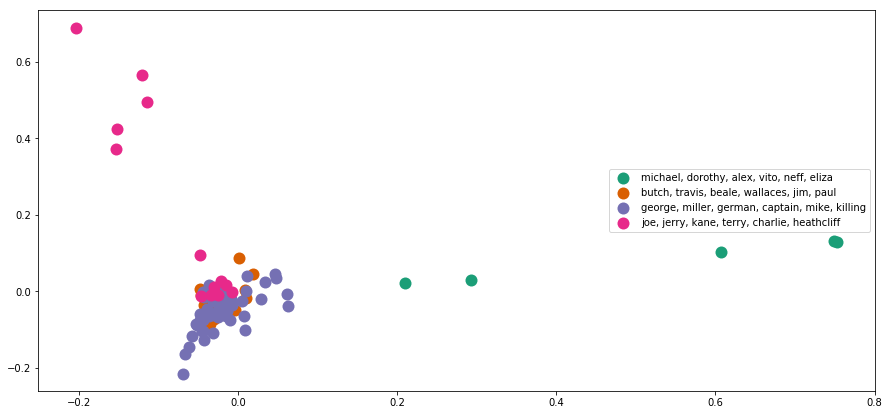

In [0]:
%matplotlib inline

# create data frame with PCA cluster results
df = pd.DataFrame(dict(x= xs, y = ys, label = clusters, title = titles))
groups = df.groupby(clusters)

#set up plot
fig, ax = plt.subplots(figsize = (15,7))
#set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker = 'o', linestyle = '', ms = 12, label =cluster_names[name], color = cluster_colors[name], mec = 'none')
ax.legend(numpoints = 1, loc = 7)  #show legend with only 1 point, position is right bottom

plt.show()

In [0]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [0]:
# use LDA for clustering

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 4, learning_method = 'online')

In [0]:
# LDA requires integer values, keep first 3 digits
tfidf_matrix_lda = tfidf_matrix*100
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [0]:
lda.fit(tfidf_matrix_lda)

# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)

(4, 2000)


In [0]:
n_top_words = 7
topic_keywords_list = []

for i, topic_dist in enumerate(topic_word):
    # Here we select top(n_top_words- 1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1]
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [0]:
# documents and topics matrix
doc_topic = lda.transform(tfidf_matrix_lda)
print(doc_topic.shape)

(100, 4)


In [0]:
# print out the clusters and topics and titles for the movie

topic_doc_dict = {}
print("<Document Clustering Result by LDA>")

for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
        
for i in topic_doc_dict:
    print('Cluster ' + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print(", ".join(topic_doc_dict[i]))
    print()

<Document Clustering Result by LDA>
Cluster 2 words: michael, dorothy, jake, dunbar, karen, jim
Cluster 2 titles (31 movies): 
The Godfather, Raging Bull, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Lawrence of Arabia, The Godfather: Part II, Chinatown, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Amadeus, From Here to Eternity, Unforgiven, A Streetcar Named Desire, An American in Paris, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Exorcist, All Quiet on the Western Front, A Place in the Sun, Annie Hall, Out of Africa, Tootsie, American Graffiti, Stagecoach, Mutiny on the Bounty, The Maltese Falcon, Double Indemnity, Rebel Without a Cause, Rear Window, North by Northwest

Cluster 3 words: andy, patton, schindler, emma, logue, scarlett
Cluster 3 titles (20 movies): 
The Shawshank Redemption, Schindler's List, Gone with the Wind, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, My Fair Lady, Doctor Zhiv

# Appendix: K-means

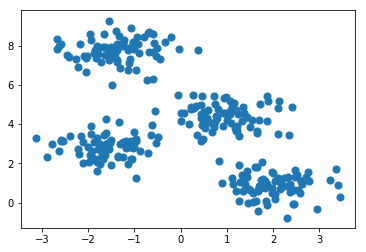

In [0]:
# An example of k-means, no relationship with above NLP case. The data is generated randomly
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples = 300, centers = 4, random_state = 0, cluster_std = 0.60 )

plt.scatter(X[:,0], X[:, 1],  s= 50)



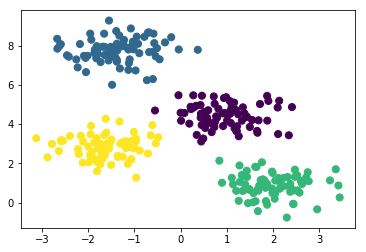

In [0]:
from sklearn.cluster import KMeans

est = KMeans(4)
est.fit(X)
y_kmeans = est.predict(X)

plt.scatter(X[:,0], X[:,1], c = y_kmeans, s = 50)